In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
import skimage.io

In [2]:
#Load Preprocessed Images and Masks
image_path = r"C:\Users\chomoj\Desktop\Machine Learning\Project\Preprocessed_Data\Images"
image_dataset = os.listdir(image_path)
backslash = "\\"

image_set = []

for i in range(0,400):
    read_image = r"C:\Users\chomoj\Desktop\Machine Learning\Project\Preprocessed_Data\Images" + backslash + image_dataset[i]
    image = skimage.io.imread(read_image)
    image_set.append(image)

os.chdir(r"C:\Users\chomoj\Desktop\Machine Learning\Project")
mask_set = np.load('Mask_Set_information.npy')


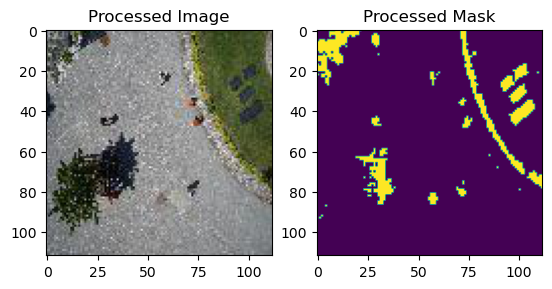

In [3]:
#Print Images to see if they loaded properly
fig, ax = plt.subplots(1,2)

ax[0].imshow(image_set[234])
ax[1].imshow(mask_set[234])

ax[0].title.set_text('Processed Image')
ax[1].title.set_text('Processed Mask')

In [4]:
#Define Image/Mask Sets as X and y
X = np.asarray(image_set)
y = mask_set
#Check Shapes of X and Y, and ensure y only has labels of 0, 1, or 2
print(X.shape)
print(y.shape)
print(np.unique(y))



(400, 112, 112, 3)
(400, 112, 112)
[0. 1. 2.]


In [5]:
#Split Test and Train data
X_train, X_test, y_train, y_test=train_test_split(
    X,y,
    test_size=0.30,
    train_size=0.70,
    random_state=123,
    shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(280, 112, 112, 3)
(120, 112, 112, 3)
(280, 112, 112)
(120, 112, 112)


In [6]:
#Create Functions to Define U-Net Network
def EncodeBlock(inputs, n_filters = 32, dropout_prob = 0.3, max_pooling = True):
   #Function performs a series of Convolution and Max Pooling to Encode Images

   #Perform Convolution
   conv = Conv2D(n_filters, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(inputs)
   conv = Conv2D(n_filters, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(conv)

   #Normalize Layer
   conv = BatchNormalization()(conv, training= False)

   #Prevent Overfitting
   if dropout_prob > 0:
     conv = Dropout(dropout_prob)(conv)

   #Perform Max Pooling
   if max_pooling:
     next_layer = MaxPooling2D(pool_size = (2,2))(conv)

   else:
     next_layer = conv

   #Save a version of the Layer before Pooling to input that data into the decoding blocks to help prevent data loss
   decode_connection = conv

   return next_layer, decode_connection


def DecodeBlock(previous_layer, encode_connection, n_filters = 32):
  #Function performs Deconvolution to Upscale the image, then merges the deconvolution of the previous layer with the 
  #encoder connection, then further performs convolution

  #Perform Deconvolution
  deconv = Conv2DTranspose(n_filters, kernel_size = 3, strides = (2,2), padding = 'same')(previous_layer)

  #Merge the Deconvolution with the Encoder Connection
  merge = concatenate([deconv, encode_connection], axis = 3)

  #Perform More Convolution for Added Processing
  conv = Conv2D(n_filters, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(merge)
  conv = Conv2D(n_filters, kernel_size = 3, activation = 'relu', padding = 'same', kernel_initializer = 'HeNormal')(conv)

  return conv

In [7]:
#Create Function to Compile the U-Net
def Unet_Compile(input_size = (112,112,3), n_filters = 32, n_class = 3):
    #Function uses the above Encoding Block Functions and Decoding Block Functions to form the basis of the U-Net
    
    #Checks the Size of an image
    inputs = Input(input_size)
    
    #Create Encoder Blocks with increasing filters
    conv_block1 = EncodeBlock(inputs,         n_filters,    dropout_prob = 0, max_pooling=True)
    conv_block2 = EncodeBlock(conv_block1[0], n_filters*2,  dropout_prob = 0, max_pooling=True)
    conv_block3 = EncodeBlock(conv_block2[0], n_filters*4,  dropout_prob = 0, max_pooling=True)
    conv_block4 = EncodeBlock(conv_block3[0], n_filters*8,  dropout_prob = 0.3, max_pooling=True)
    conv_block5 = EncodeBlock(conv_block4[0], n_filters*16, dropout_prob = 0.3, max_pooling=False)
    
    #Create Decoder Blocks with decreasing filters and use the skip connections from the Encoders
    deconv_block6 = DecodeBlock(conv_block5[0], conv_block4[1], n_filters*8)
    deconv_block7 = DecodeBlock(deconv_block6,  conv_block3[1], n_filters*4)
    deconv_block8 = DecodeBlock(deconv_block7,  conv_block2[1], n_filters*2)
    deconv_block9 = DecodeBlock(deconv_block8,  conv_block1[1], n_filters)
    
    #Use a final convolutional layer
    conv10 = Conv2D(n_filters, kernel_size = 3, activation = 'relu', padding = 'same', 
                    kernel_initializer = 'he_normal')(deconv_block9)
    
    #Use a 1x1 layer to get image to desired size
    
    conv11 = Conv2D(n_class, 1, padding='same')(conv10)
    
    #Define Model
    model = tf.keras.Model(inputs = inputs, outputs = conv11)
    
    return model
    

In [8]:
unet = Unet_Compile(input_size=(112,112,3), n_filters=32, n_class = 3)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_15 (Conv2D)             (None, 56, 56, 64)   36928       ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 112, 112, 32  18464      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 112, 112, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'batch_normalization[0][0]']    
                                                                                                  
 conv2d_16 (Conv2D)             (None, 112, 112, 32  18464       ['concatenate_3[0][0]']          
                                )                                                                 
          

In [9]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
            loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

In [10]:
results = unet.fit(X_train, y_train, batch_size=8, epochs = 50, validation_data=(X_test,y_test))

Epoch 1/50
35/35 [==============================] - 45s 1s/step - loss: 8.2106 - accuracy: 0.6883 - val_loss: 1.8266 - val_accuracy: 0.6741
Epoch 2/50
35/35 [==============================] - 41s 1s/step - loss: 1.3092 - accuracy: 0.7150 - val_loss: 0.9928 - val_accuracy: 0.7345
Epoch 3/50
35/35 [==============================] - 41s 1s/step - loss: 0.7836 - accuracy: 0.7376 - val_loss: 0.6889 - val_accuracy: 0.7143
Epoch 4/50
35/35 [==============================] - 42s 1s/step - loss: 0.6161 - accuracy: 0.7533 - val_loss: 0.5837 - val_accuracy: 0.7577
Epoch 5/50
35/35 [==============================] - 41s 1s/step - loss: 0.5439 - accuracy: 0.7641 - val_loss: 0.5365 - val_accuracy: 0.7539
Epoch 6/50
35/35 [==============================] - 41s 1s/step - loss: 0.5166 - accuracy: 0.7718 - val_loss: 0.5257 - val_accuracy: 0.7696
Epoch 7/50
35/35 [==============================] - 41s 1s/step - loss: 0.5150 - accuracy: 0.7717 - val_loss: 0.5095 - val_accuracy: 0.7678
Epoch 8/50
35/35 [==

1/1 [==============================] - 0s 55ms/step


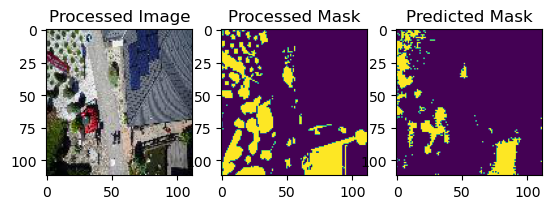

In [41]:
#Print Images to see if they loaded properly
index = 115
img = X_test[index]
img = img[np.newaxis, ...]
pred = unet.predict(img)
pred_mask = tf.argmax(pred[0], axis=-1)
pred_mask = pred_mask[..., tf.newaxis]


fig, ax = plt.subplots(1,3)

ax[0].imshow(X_test[index])
ax[1].imshow(y_test[index])
ax[2].imshow(pred_mask[:,:,0])

ax[0].title.set_text('Processed Image')
ax[1].title.set_text('Processed Mask')
ax[2].title.set_text('Predicted Mask')

In [12]:
#Define True Positive, False Positive, True Negative, and Fasle Negative for Test set
# 1 is safe to land, 2 is not safe to land. Let 1 be the positive class
tp = 0
fp = 0
tn = 0
fn = 0

#Gather a total of all True Positive, False Positive, True Negative, and False Negatives for the test dataset.
for image in range(0,X_test.shape[0]):
    img = X_test[image]
    img = img[np.newaxis, ...]
    pred = unet.predict(img)
    pred_mask = tf.argmax(pred[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    print(image)
    
    for i in range(0, X_test.shape[1]):
        for j in range(0, X_test.shape[2]):
            
            if pred_mask[i][j][0].numpy() == 1:
                
                if y_test[image][i][j] == 1:
                    #If Predicted to be Safe, and is Safe, then True Positive
                    tp = tp + 1
                
                else:
                    #If Predicted to be Safe and is Not Safe, then False Positive
                    fp = fp + 1
                    
            elif pred_mask[i][j][0].numpy() == 2:
                
                if y_test[image][i][j] == 2:
                    #If Predicted to be Not Safe and is Not Safe, then True Negative
                    tn = tn + 1
                    
                else:
                    #If Predicted to be Not Safe and is Safe, then False Negative
                    fn = fn + 1
print('True Positive = ', tp)
print('False Positive = ',fp)
print('True Negative = ', tn)
print('False Negative = ', fn)

1/1 [==============================] - 0s 53ms/step
0
1/1 [==============================] - 0s 63ms/step
1
1/1 [==============================] - 0s 56ms/step
2
1/1 [==============================] - 0s 54ms/step
3
1/1 [==============================] - 0s 52ms/step
4
1/1 [==============================] - 0s 50ms/step
5
1/1 [==============================] - 0s 49ms/step
6
1/1 [==============================] - 0s 51ms/step
7
1/1 [==============================] - 0s 50ms/step
8
1/1 [==============================] - 0s 50ms/step
9
1/1 [==============================] - 0s 50ms/step
10
1/1 [==============================] - 0s 52ms/step
11
1/1 [==============================] - 0s 51ms/step
12
1/1 [==============================] - 0s 51ms/step
13
1/1 [==============================] - 0s 52ms/step
14
1/1 [==============================] - 0s 52ms/step
15
1/1 [==============================] - 0s 50ms/step
16
1/1 [==============================] - 0s 54ms/step
17
1/1 [===============

In [13]:
#Evaluate Metrics Using the above metrics

Accuracy = (tp+tn)/(tp+fp+tn+fn)
print('Accuracy of the model is ', Accuracy)

Precision_Safe = tp/ (tp + fp)
Precision_Not_Safe = tn / (tn + fn)
print('Precision for Identifying Safe Landing Zone is ', Precision_Safe)
print('Precision for Identifying Unsafe Landing Zone is ', Precision_Not_Safe)

Recall_Safe = tp/ (tp+fn)
Recall_Not_Safe = tn / (tn + fp)
print('Recall for Identifying Safe Landing Zone is ', Recall_Safe)
print('Recall for Identifying Unsafe Landing Zone is ', Recall_Not_Safe)

IoU = tp / (tp+fp+fn)
print('Intersection over Union Score is ', IoU)

Accuracy of the model is  0.8139030612244897
Precision for Identifying Safe Landing Zone is  0.8196198202315116
Precision for Identifying Unsafe Landing Zone is  0.7407811197332136
Recall for Identifying Safe Landing Zone is  0.975870488295558
Recall for Identifying Unsafe Landing Zone is  0.24303933680201747
Intersection over Union Score is  0.8033393170427605


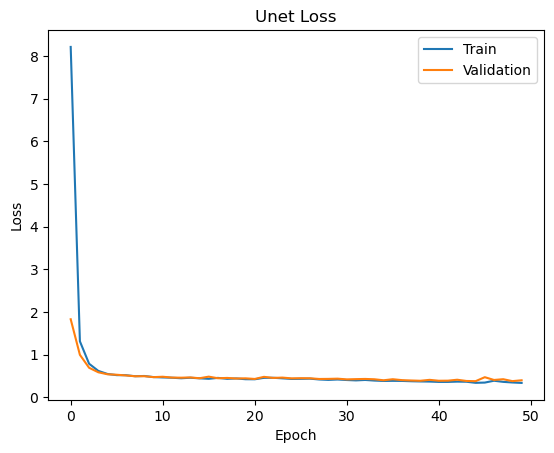

In [14]:
#Plot Model Loss and Accuracy

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Unet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

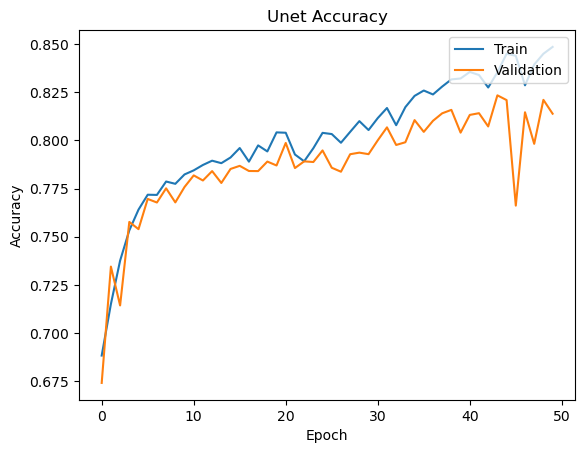

In [15]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Unet Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()